<a href="https://colab.research.google.com/github/BryanDYang/LSTM_RNN_Stock_Market/blob/main/LSTM_RNN_Stock_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project Description: This program uses an artificial recurrence neural network called Long Short Term Memory (LSTM)
#                      to predict the closing stock price of various companies using the past 60 day stock price.

In [1]:
# Import the libraries
import tensorflow as tf
import math
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [ ]:
# Latest Fix for the Yahoo Finance API Link with Colab
!pip install pycryptodome pycryptodomex
!pip uninstall --yes pandas-datareader
!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316

In [12]:
# Interactive Input from the User
def start_input():
  global start_date
  start_date = input("Put Start Date in MM-DD-YYYY format: ")
  # Try one more time for the trader
  try:
    return start_date
  except:
    print('That is not a correct format! \nPlease try again.')
    start_date = input("Put Start Date in MM-DD-YYYY format: ")

def end_input():
  global end_date
  end_date = input("Put End Date in MM-DD-YYYY format: ")
  # Try one more time for the trader
  try:
    return end_date
  except:
    print('That is not a correct format! \nPlease try again.')
    end_date = input("Put End Date in MM-DD-YYYY format: ")

# Latest Time
source = 'yahoo'
ticker = input("Put a desired Ticker Symbol: ")

# Get the stock quote
df = pdr.DataReader(ticker, data_source=source, start=start_input(), end=end_input())

# Show the Data
df

Put a desired Ticker Symbol: MSFT
Put Start Date in MM-DD-YYYY format: 12-01-2010
Put End Date in MM-DD-YYYY format: today


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-01,26.250000,25.559999,25.570000,26.040001,74123500.0,20.340927
2010-12-02,26.980000,26.200001,26.240000,26.889999,91759200.0,21.004890
2010-12-03,27.059999,26.780001,26.809999,27.020000,52622000.0,21.106436
2010-12-06,26.980000,26.760000,26.930000,26.840000,36264200.0,20.965830
2010-12-07,27.129999,26.850000,27.080000,26.870001,57860500.0,20.989267
...,...,...,...,...,...,...
2022-12-19,245.210007,238.710007,244.860001,240.449997,29696400.0,240.449997
2022-12-20,242.910004,238.419998,239.399994,241.800003,25150800.0,241.800003
2022-12-21,245.619995,240.110001,241.690002,244.429993,23690600.0,244.429993


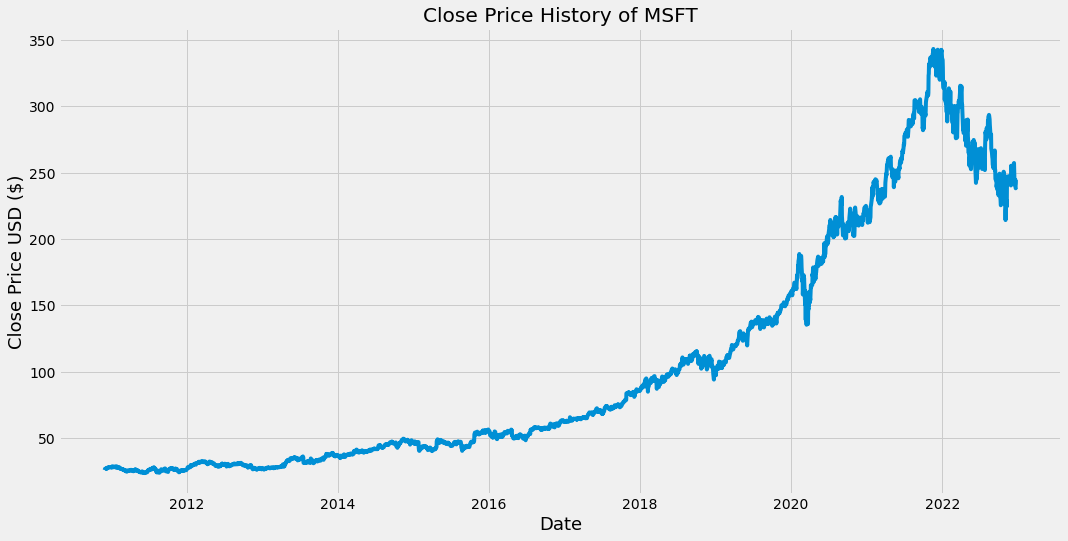

In [13]:
# Descriptive: Visualize the history of the closing price
plt.figure(figsize=(16,8))
plt.title(f'Close Price History of {ticker}')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [14]:
# Descriptive (Summary) Statstics
df[['High',	'Low',	'Open',	'Close',	'Volume',	'Adj Close']].describe()

,High,Low,Open,Close,Volume,Adj Close
count,3038.000000,3038.000000,3038.000000,3038.000000,3.038000e+03,3038.000000
mean,106.485767,104.344457,105.440346,105.468222,3.602326e+07,100.780831
std,90.012789,88.003949,89.048846,89.051406,1.982275e+07,90.040445
min,24.010000,23.650000,23.750000,23.709999,7.425600e+06,18.752441
25%,36.889999,36.235000,36.795001,36.645000,2.340568e+07,31.118025
50%,62.480000,61.835001,62.004999,62.154999,3.099910e+07,57.253883
75%,152.389999,150.007496,151.052505,151.327499,4.333200e+07,147.117943
max,349.670013,342.200012,344.619995,343.109985,3.193179e+08,339.924835


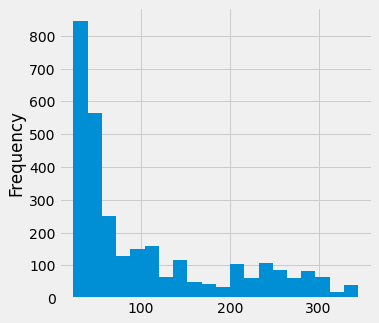

In [15]:
# Descriptive (Summary) Statstics in histogram plot for open vs closing price
# historgram plot of open price
df['Open'].plot(kind='hist', bins=20, figsize=(5,5,))

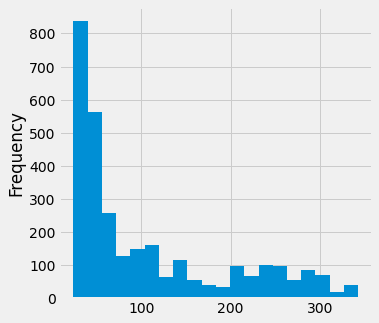

In [16]:
# Descriptive (Summary) Statstics in histogram plot for open vs closing price
# historgram plot of close price
df['Close'].plot(kind='hist', bins=20, figsize=(5,5,))

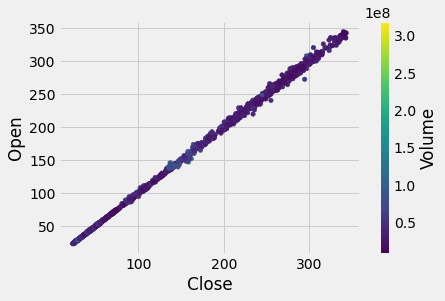

In [17]:
# Descriptive (Summary) Statstics in scatter plot of Open vs Close Price colored in Volume
df.plot.scatter(x= 'Close', y='Open', c='Volume', colormap='viridis')

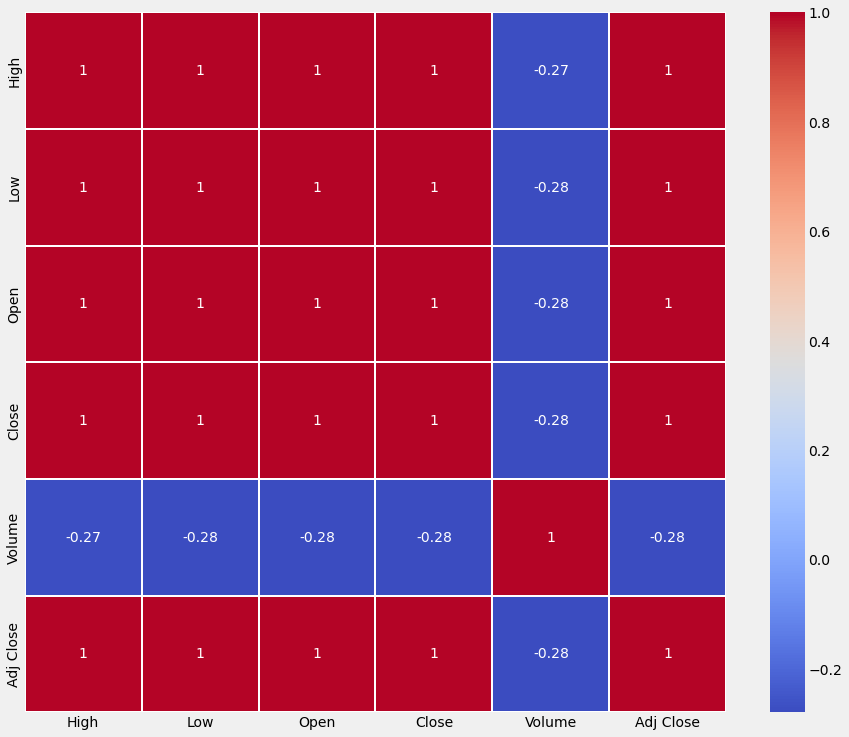

In [18]:
# Descriptive (Summary) Correlation Matrix 
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidth=1)
plt.show()

In [19]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the LSTM Model on
training_data_len = math.ceil(len(dataset) * 0.8)

# Print dataset length
training_data_len

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create training dataset
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
# x_train <- independent variables
x_train = []
# y_train <- dependent variables
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()  

[array([0.00729493, 0.00995617, 0.01036319, 0.00979963, 0.00989356,
       0.01102067, 0.01055104, 0.01136506, 0.01108328, 0.01224171,
       0.01296181, 0.01340013, 0.01311835, 0.01283657, 0.0136506 ,
       0.0140263 , 0.0143707 , 0.0136506 , 0.01346275, 0.01333751,
       0.01296181, 0.01314966, 0.01336882, 0.01371322, 0.01343144,
       0.01599875, 0.01530996, 0.01412023, 0.01377584, 0.01515341,
       0.0140263 , 0.0143707 , 0.01549781, 0.01490294, 0.01452724,
       0.01349406, 0.01462117, 0.01484033, 0.01587352, 0.0161553 ,
       0.01264872, 0.0125861 , 0.01340013, 0.01324359, 0.01233563,
       0.01271134, 0.01405761, 0.01430808, 0.01333751, 0.011866  ,
       0.01108328, 0.01102067, 0.01017533, 0.01036319, 0.01095805,
       0.01048842, 0.00901691, 0.00901691, 0.00958047, 0.00889167])]
[0.008985601010118499]

[array([0.00729493, 0.00995617, 0.01036319, 0.00979963, 0.00989356,
       0.01102067, 0.01055104, 0.01136506, 0.01108328, 0.01224171,
       0.01296181, 0.01340013, 0.0

In [20]:
# Convert the x_train and y_train to numpy arrays to use to train LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train dataset from 2D to 3D for LSTM
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2371, 60, 1)

In [21]:
# Build the LSTM model and add layers
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2371/2371 [==============================] - 74s 30ms/step - loss: 4.9714e-04


In [22]:
# Create the testing dataset
# Create a new array containing scaled values from index 1555 to 2015
test_data = scaled_data[training_data_len - 60:, :]

# Create the datasets x_test and y_test
# x_test contains past 60-day values
x_test = []
# y_test contains 61st value for prediction
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# Convert the data into to a numpy array
x_test = np.array(x_test)

# Reshape the data from 2D to 3D for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RSME) for fit test
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

19/19 [==============================] - 1s 19ms/step


3.0860572576130045

<ipython-input-23-b89c420fb31a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


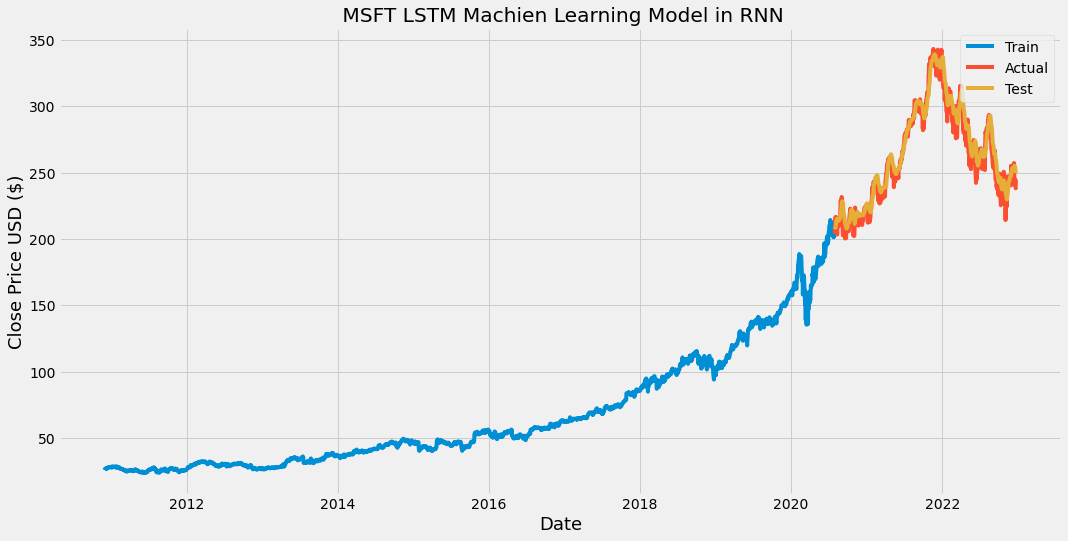

In [23]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# None-Discriptive (predictive or prescriptive): Visualize the data
plt.figure(figsize=(16,8))
plt.title(f' {ticker} LSTM Machien Learning Model in RNN')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Test'], loc='upper right')
plt.show()

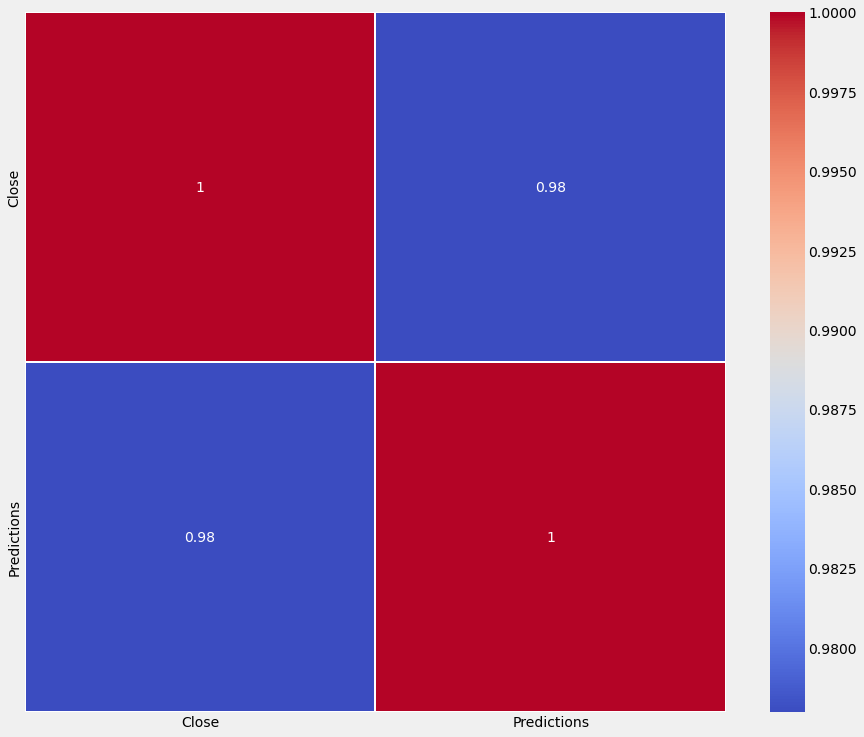

In [24]:
# Non-Descriptive Correlation Matrix 
plt.figure(figsize=(14, 12))
sns.heatmap(valid.corr(), annot=True, cmap="coolwarm", linewidth=1)
plt.show()

In [25]:
# Show the Actual and Test Closing prices
valid

,Close,Predictions
Date,,
2020-07-30,203.899994,209.124115
2020-07-31,205.009995,208.714325
2020-08-03,216.539993,208.553238
2020-08-04,213.289993,209.750565
2020-08-05,212.940002,211.130844
...,...,...
2022-12-19,240.449997,254.748520
2022-12-20,241.800003,253.484131
2022-12-21,244.429993,252.084305


In [26]:
# This section is for prediciton of the model based on the past 60-day stock performance

backtest_quote = pdr.DataReader(ticker, data_source = source, start=start_date, end=end_date)

# Create a new dataframe
new_df = backtest_quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days to the X_test
X_test.append(last_60_days_scaled)

# Convert the X_test data 
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)

print(end_date)
print(pred_price)

1/1 [==============================] - 0s 27ms/step
today
[[248.12157]]


In [27]:
# Get the actual closing price as a back-test 
# Note:Using 'today' as end date will result in error when the market didn't close for the day. 
#      When the market is still open, today's value will be null or NaN
actual_quote = pdr.DataReader(ticker, data_source = source, start=end_date, end=end_date)
print(actual_quote['Close'])

KeyError: ignored